In [2]:
import os
from dotenv import load_dotenv
from IPython.display import Image, display
from pprint import pprint
from typing import List
from typing_extensions import TypedDict

In [54]:
from langchain import hub
from langchain.llms import Ollama
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.retrievers import ArxivRetriever

from langgraph.graph import StateGraph, START, END

In [3]:
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY")

### Indexing

In [31]:
rag_best_practices_url = "https://arxiv.org/pdf/2407.01219"

arxiv_retriever = ArxivRetriever(load_max_docs=2)
arxiv_docs = arxiv_retriever.invoke("2407.01219", get_full_document=False, load_all_available_meta=False)
print(arxiv_docs[0].metadata)
for doc in arxiv_docs:
    doc.metadata["Published"] = str(doc.metadata["Published"])
print(arxiv_docs[0].metadata)

{'Entry ID': 'http://arxiv.org/abs/2407.01219v1', 'Published': datetime.date(2024, 7, 1), 'Title': 'Searching for Best Practices in Retrieval-Augmented Generation', 'Authors': 'Xiaohua Wang, Zhenghua Wang, Xuan Gao, Feiran Zhang, Yixin Wu, Zhibo Xu, Tianyuan Shi, Zhengyuan Wang, Shizheng Li, Qi Qian, Ruicheng Yin, Changze Lv, Xiaoqing Zheng, Xuanjing Huang'}
{'Entry ID': 'http://arxiv.org/abs/2407.01219v1', 'Published': '2024-07-01', 'Title': 'Searching for Best Practices in Retrieval-Augmented Generation', 'Authors': 'Xiaohua Wang, Zhenghua Wang, Xuan Gao, Feiran Zhang, Yixin Wu, Zhibo Xu, Tianyuan Shi, Zhengyuan Wang, Shizheng Li, Qi Qian, Ruicheng Yin, Changze Lv, Xiaoqing Zheng, Xuanjing Huang'}


In [32]:
urls = [
    "https://huyenchip.com/2024/01/16/sampling.html#constraint_sampling",
    "https://huyenchip.com/2024/07/25/genai-platform.html", 
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [33]:
docs_list.extend(arxiv_docs)
len(docs_list)

3

### Retriever

In [35]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=20)
doc_splits = text_splitter.split_documents(docs_list)

nomic137M_embeddings = OllamaEmbeddings(model="nomic-embed-text")


vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name = "rag_best_approaches_genAI_apps",
    persist_directory="./vectorstore_files",
    embedding = nomic137M_embeddings,
)

rag_related_retriever = vectorstore.as_retriever()

#### Retrieval grader: [llm as a judge]

In [36]:
llm = ChatOllama(model="mistral", format="json", temperature=0)

retrieval_grader_prompt = PromptTemplate(
    template = """You are a grader assessing the relevance of the retrieved document to a user question. \n
    If the doument contains keywords related to user's question, then grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter our erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide binary score as a JSON with a single key 'score' and no preamble or explanation. \n\n
    User question: {question} \n
    Retrieved document: \n\n {document} \n\n
""",
input_variables = ["question", "document"]
)

retriever_grader_chain = retrieval_grader_prompt | llm | JsonOutputParser()

In [38]:
question = "top chunking strategies"
docs = rag_related_retriever.get_relevant_documents(question)
sample_doc_text = docs[2].page_content
print(sample_doc_text)
for doc in docs:
    print(retriever_grader_chain.invoke({"question": question, "document": doc.page_content}))

/home/srivatsa/my_jupyter_noteboks/agentic_and_rag/lang_chain/lang_graph/.venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


Top-k
Top-k is a sampling strategy to reduce the computation workload without sacrificing too much of the model’s response diversity. Recall that to compute the probability distribution over all possible values, a softmax layer is used. Softmax requires two passes over all possible values: one to perform the exponential sum \(\sum_j e^{x_j}\) and one to perform \(\frac{e^{x_i}}{\sum_j e^{x_j}}\) for each value. For a language model with a large vocabulary, this process is computationally expensive.
To avoid this problem, after the model has computed the logits, we pick the top k logits and perform softmax over these top k logits only. Depending on how diverse you want your application to be, k can be anywhere from 50 to 500, much smaller than a model’s vocabulary size. The model then samples from these top values. A smaller k value makes the text more predictable but less interesting, as the model is limited to a smaller set of likely words.
Top-p
{'score': 'yes'}
{'score': 'yes'}
{'sc

#### Rag Chain

In [39]:
rag_prompt = hub.pull("rlm/rag-prompt")
print(rag_prompt)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = rag_prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

input_variables=['context', 'question'] metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]
{
"top chunking strategies": "To learn more about chunking and the optimal chunk size, see Pinecone, Langchain, Llamaindex, and Greg Kamradt's tutorials.",
"prompt cache": "Many prompts in an application have overlapping text segments. For example, all queries can share the same system prompt. A prompt cache stores these overlapping segments for reuse, so you only need to process them once.",
"exact 

#### Hallucination Grader [llm as a judge]

In [40]:
# Hallucination Grader

prompt = PromptTemplate(
    template = """You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n
    Facts:
    \n\n
    {documents}
    \n\n
    Answers: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables = ["generation", "documents"]
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

#### Answer Grader

In [41]:
answer_grader_prompt = PromptTemplate(
    template = """You are a grader assessing whether an answer is useful to resolve a question. \n
    Give a binary score 'yes' or 'no' score to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.\n
    Question: {question}\n\n
    Answer: {generation} 
    """,
    input_variables = ["question", "generation"]
)

answer_grader = answer_grader_prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

#### Query Rewriter

In [45]:
llm_no_json = ChatOllama(model="mistral", temperature=0) #the format is not json here

re_write_prompt = PromptTemplate(
    template = """You are a question re-writer that converts an input question to a better version that is organized for vectorstore retrieval. \n
    Look at the initial and formulate an improved question. \n
    Here is the initial question: \n 
    {question} \n 
    Improved question with no preamble: """,
    input_variables={"question": question}
)

question_rewriter = re_write_prompt | llm_no_json | StrOutputParser()
question_rewriter.invoke({"question": question})

'\n    What are some effective top chunking strategies for improving vectorstore retrieval?'

## Capturing the flow in a Graph

#### Graph State

In [46]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

#### Graph Functions (Nodes)

In [67]:
def retrieve(state: GraphState) -> dict:
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("__Retrieve__")
    question = state["question"]
    documents = rag_related_retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state: GraphState) -> dict:
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("__Generate__")
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"question": question, "context": documents})
    return {"documents": documents, "question": question, "generation":generation}

def grade_documnents(state: GraphState) -> dict:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("__Check document relevance to question__")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    for doc in documents:
        result = retriever_grader_chain.invoke({"question": question, "document": doc.page_content})
        grade = result["score"]
        if grade.lower() == "yes":
            print("__document is deemed relevant__")
            filtered_docs.append(doc)
        else:
            print("__Document is irrelevant__")
    print(f"__{len(filtered_docs)} out of {len(docs)} docs were deemed relevant__")
    return {"document": filtered_docs, "question": question}

def transform_query(state: GraphState) -> dict:
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
    """
    question = state["question"]
    documents = state["documents"]
    print("__Rewriting Question__")
    better_question = question_rewriter.invoke({"question": question})
    print("Better question:", better_question)
    return {"question": better_question, "documents": documents}

def decide_to_generate(state: GraphState) -> str:
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    question = state["question"]
    filtered_documents = state["documents"]
    if not filtered_documents:
        print("__all documents are irrelevant to question__")
        return "transform_query"
    else:
        print("__Ready to generate__")
        return "generate"
    
def grade_generation_v_documents_and_question(state: GraphState) -> str:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("__Checking for Hallucination__")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    no_hallucination = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = no_hallucination["score"]
    if grade == "yes":
        print("__Generation is grounded in documents__")
        #check question-answering
        result = answer_grader.invoke({"question": question, "generation": generation})
        grade = result["score"]
        if grade == "yes":
            print("__Generation addresses question__")
            return "useful"
        else:
            print("__generation does not address the question__")
            return "not_useful"
    else:
        print("__Generation is not grounded in the documents; DECISION: __Re-Try__")
        return "not_supported"

#### Graph workflow

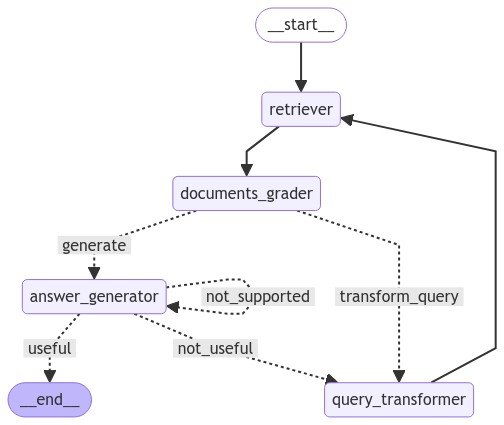

In [71]:
workflow = StateGraph(GraphState)

#nodes
workflow.add_node("retriever", retrieve)
workflow.add_node("documents_grader", grade_documnents)
workflow.add_node("answer_generator", generate)
workflow.add_node("query_transformer", transform_query)

#edges
workflow.add_edge(START, "retriever")
workflow.add_edge("retriever", "documents_grader")
workflow.add_conditional_edges(
    "documents_grader",
    decide_to_generate, #note that decide to generate is not a node; just a function
    {
        "generate": "answer_generator",
        "transform_query": "query_transformer",
    },
)
workflow.add_edge("query_transformer", "retriever")
workflow.add_conditional_edges(
    "answer_generator",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not_useful": "query_transformer",
        "not_supported": "answer_generator"
    }
)

self_rag = workflow.compile()
display(Image(self_rag.get_graph(xray=True).draw_mermaid_png(), height=750, width=800))

In [65]:
# display(Image(self_rag.get_graph(xray=True).draw_mermaid_png(), height=1000, width=1000))

In [75]:
def query(question:str):
    inputs = {"question": question}
    for output in self_rag.stream(inputs):
        for key, value in output.items():
            pprint(f"Node: {key}:")
        pprint("\n___________________________________\n")

    print("Final Generation:\n",value["generation"])

Final Generation:
 {
"chunking": "cache",
"strategies": ["prompt cache", "exact cache"],
"description": "Cache techniques can significantly reduce your application’s latency and cost. Prompt cache are typically implemented by the inference APIs that you use. Exact cache is more general and straightforward, storing processed items for reuse later when the exact items are requested."
}
